In [373]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from fuzzywuzzy import fuzz, process

In [374]:
def add_date_data(DF):
    DF['year']=0
    DF['month']=0
    DF['month_day']=0
    DF['year_day']=0
    DF['weekday']=0

    for ind in DF.index:
        date=DF.date[ind]
        date_st=date.timetuple()
        DF.loc[ind,'year']=date_st.tm_year
        DF.loc[ind,'month']=date_st.tm_mon
        DF.loc[ind,'month_day']=date_st.tm_mday
        DF.loc[ind,'year_day']=date_st.tm_yday
        DF.loc[ind,'weekday']=date_st.tm_wday
    return DF

In [375]:
def add_date_data(DF):
    DF_dates=pd.DataFrame({'date':DF.date.unique(),'year':0,
                          'month':0,'month_day':0,
                          'year_day':0,'weekday':0,
                          'week':0})

    for ind in DF_dates.index:
        date=DF_dates.date[ind]
        date_st=date.timetuple()
        DF_dates.loc[ind,'year']=date_st.tm_year
        DF_dates.loc[ind,'month']=date_st.tm_mon
        DF_dates.loc[ind,'month_day']=date_st.tm_mday
        DF_dates.loc[ind,'year_day']=date_st.tm_yday
        DF_dates.loc[ind,'weekday']=date_st.tm_wday
        DF_dates.loc[ind,'week']=date.isocalendar()[1]
        
        
    DF=DF.merge(DF_dates, on='date')
    return DF

In [401]:
DF_energy=pd.read_csv('../../Data/subsystem_all_dams/Energy_generated_daily_by_dam.csv.zip')
DF_energy['date']=pd.to_datetime(DF_energy.date)

In [402]:
DF_flow=pd.read_csv('../../Data/subsystem_all_dams/Influent_flow_daily_by_dam.csv.zip')
DF_flow['date']=pd.to_datetime(DF_flow.date)

In [509]:
A=DF_flow.dam.unique()
B=DF_energy.dam.unique()

Name_matching=pd.DataFrame({'dam_flow':A,'dam_energy':'', 'score':0})
for ind in Name_matching.index:
    a=Name_matching.loc[ind,'dam_flow']
    b, score=process.extractOne(a,B)
    Name_matching.loc[ind,['dam_energy','score']]=[b,score]

In [510]:
Name_matching[((Name_matching.score>=90) & (Name_matching.score<100))| (Name_matching.dam_energy==' BARRA BONITA')].sort_values('score')

,dam_flow,dam_energy,score
154,B. BONITA,BARRA BONITA,82
0,SINOP,UHE SINOP,90
116,FONTES,FONTES NOVA (A+BC+SC),90
113,FUNIL,FUNIL (FURNAS),90
105,GUILM. AMORIM,GUILMAN - AMORIM,90
104,HENRY BORDEN,COMPLEXO HENRY BORDEN + pedreira + traição,90
98,ITÁ,ITUTINGA,90
94,ITIQUIRA I,ITIQUIRA I + ITIQUIRA II,90
93,ITIQUIRA II,ITIQUIRA I + ITIQUIRA II,90
92,ITUMBIARA,ITUMBIARA (FURNAS),90


In [511]:
incorrect_matching=['SALTO', 'ANTA', 'ITÁ']

In [513]:
Name_matching=Name_matching[((Name_matching.score>=90) &\
                            ([not(name in incorrect_matching) for name in Name_matching.dam_flow])) |\
                            (Name_matching.dam_energy==' BARRA BONITA')][['dam_flow','dam_energy']]

In [529]:
All_DF=DF_flow.merge(Name_matching,how='inner',left_on='dam', right_on='dam_flow').drop('dam',axis=1)

In [530]:
All_DF=All_DF.merge(DF_energy, how='inner',left_on=['date','dam_energy'], right_on=['date','dam']).drop('dam',axis=1)

In [531]:
All_DF=add_date_data(All_DF)

In [569]:
#Now we  aggregate
All_DF_monthly=All_DF.groupby(['year','month','dam_energy']).agg(energy_generated=('energy_generated','sum'),influent_flow=('influent_flow','sum'),
                                                 dam_flow=('dam_flow',lambda x: ' & '.join([str(a) for a in x.unique()])),
                                                 maximum_demand=('maximum_demand','sum')).reset_index()
All_DF_monthly

,year,month,dam_energy,energy_generated,influent_flow,dam_flow,maximum_demand
0,2000,1,BARRA BONITA,42.058100,17948.34,B. BONITA,937624.000
1,2000,1,CACONDE,23.880900,3699.81,CACONDE,937624.000
2,2000,1,CAMARGOS,28.066200,9268.10,CAMARGOS,937624.000
3,2000,1,CANOAS I,1.731600,17097.77,CANOAS I,937624.000
4,2000,1,CANOAS II,1.333300,16505.08,CANOAS II,937624.000
...,...,...,...,...,...,...,...
12523,2019,12,TELES PIRES,839.582770,69404.84,TELES PIRES,1315998.779
12524,2019,12,TRÊS IRMÃOS,290.170607,24632.62,TRÊS IRMÃOS,1315998.779
12525,2019,12,TRÊS MARIAS,91.413588,21718.65,TRÊS MARIAS,1315998.779
12526,2019,12,UHE SINOP,136.994015,24539.01,SINOP,1315998.779


In [533]:
import random
from plotnine import *

In [571]:
Corr_DF=pd.DataFrame({'dam_energy':All_DF.dam_energy.unique(),'corr_energy':0,'corr_demand':0})
for ind in Corr_DF.index:
    dam=Corr_DF.loc[ind,'dam_energy']
    DF=All_DF_monthly[All_DF_monthly.dam_energy==dam]
    Corr_DF.loc[ind,'corr_energy']=np.corrcoef(DF.energy_generated, DF.influent_flow)[0,1]
    Corr_DF.loc[ind,'corr_demand']=np.corrcoef(DF.energy_generated, DF.maximum_demand)[0,1]

In [572]:
Corr_DF.sort_values('corr_demand', ascending=False).head(10)

,dam_energy,corr_energy,corr_demand
50,ESPORA,0.605573,0.688297
22,PONTE DE PEDRA,0.872542,0.684342
35,JAURU,0.712957,0.558185
0,UHE SINOP,0.736078,0.504208
16,RONDON II,0.642007,0.483327
1,SAO MANOEL,0.495527,0.444098
40,ITIQUIRA I + ITIQUIRA II,0.536377,0.430300
19,ENG. SERGIO MOTA (PORTO PRIMAVERA),0.264807,0.384149
6,TELES PIRES,0.872383,0.318706
52,DARDANELOS,0.853015,0.318079


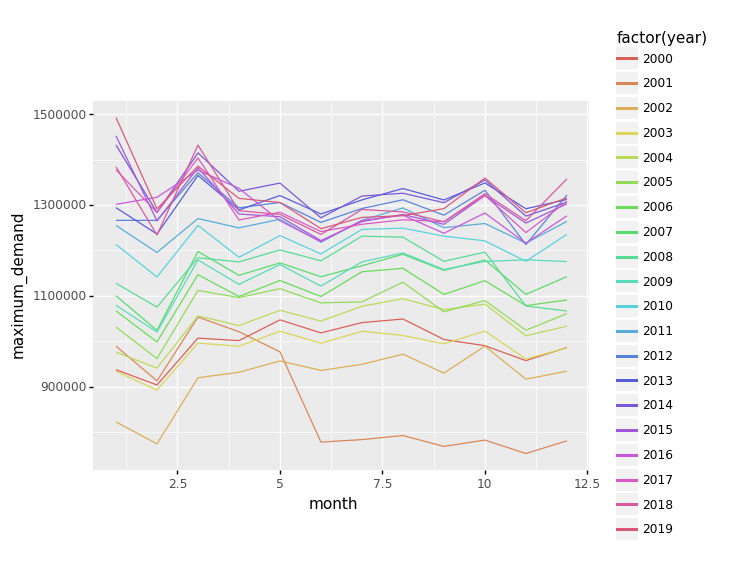

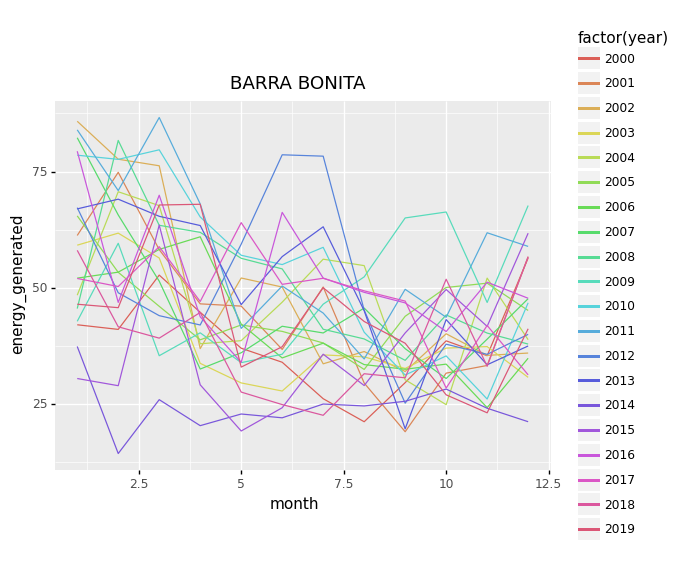

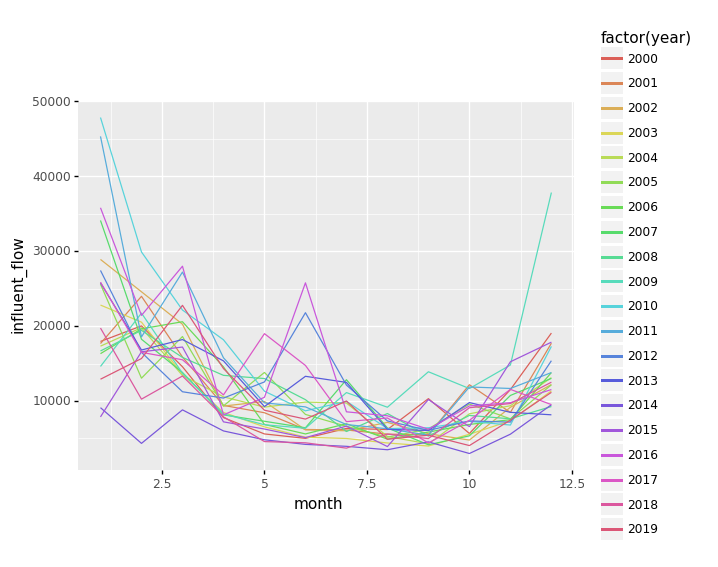

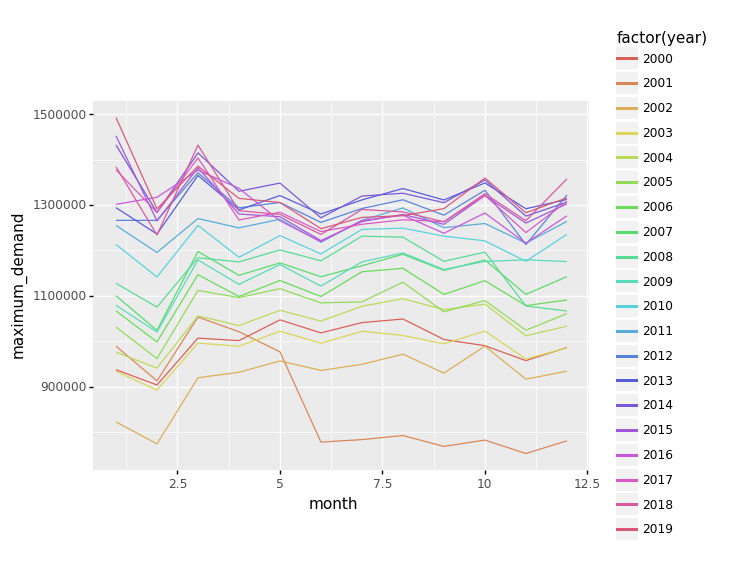

In [577]:
dam=' BARRA BONITA'
DF2=All_DF_monthly[All_DF_monthly.dam_energy==dam]

G1=ggplot(DF2,aes(x='month',y='energy_generated',color='factor(year)'))+geom_line()+ggtitle(dam)
G2=ggplot(DF2,aes(x='month',y='influent_flow',color='factor(year)'))+geom_line()
G3=ggplot(DF2,aes(x='month',y='maximum_demand',color='factor(year)'))+geom_line()

G1.draw()
G2.draw()
G3.draw()

In [537]:
Corr_DF_daily=pd.DataFrame({'dam_energy':All_DF.dam_energy.unique(),'corr':0})
for ind in Corr_DF_daily.index:
    dam=Corr_DF.loc[ind,'dam_energy']
    DF=All_DF[All_DF.dam_energy==dam]
    Corr_DF_daily.loc[ind,'corr']=np.corrcoef(DF.energy_generated, DF.influent_flow)[0,1]
Corr_DF_daily['abs_corr']=np.abs(Corr_DF_daily['corr'])

In [542]:
Corr_DF_daily.sort_values('abs_corr',ascending=False).head(10)

,dam_energy,corr,abs_corr
56,CANA BRAVA,0.867387,0.867387
38,ITUTINGA,0.865769,0.865769
6,TELES PIRES,0.865394,0.865394
11,SANTA BRANCA,0.853835,0.853835
10,SÃO SALVADOR,0.823402,0.823402
30,MIRANDA,0.822909,0.822909
52,DARDANELOS,0.817193,0.817193
3,VOLTA GRANDE (CEMIG),0.808434,0.808434
43,IGARAPAVA,0.800972,0.800972
24,PICADA,0.783977,0.783977


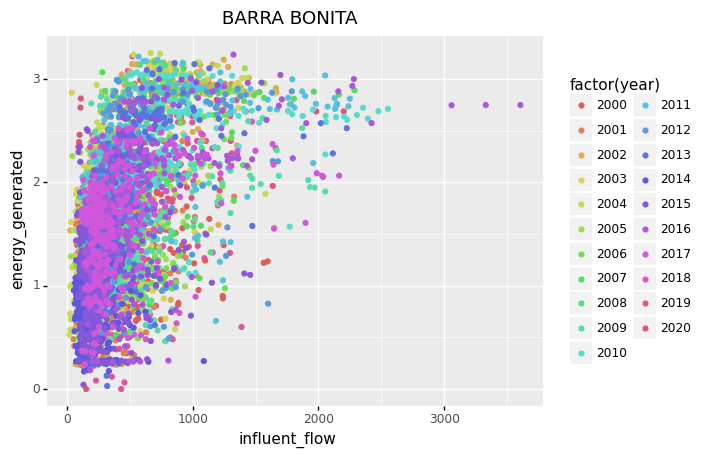

<ggplot: (142857556779)>

In [554]:
dam=' BARRA BONITA'
DF2=All_DF[All_DF.dam_energy==dam]

ggplot(DF2,aes(x='influent_flow',y='energy_generated',color='factor(year)'))+geom_point()+ggtitle(dam)

In [556]:
DF_Demand=pd.read_csv('../../Data/1999_2021/aggragate_daily_data_2000to2020.csv')
DF_Demand=DF_Demand[['date','maximum_demand']]
DF_Demand.date=pd.to_datetime(DF_Demand.date)

In [557]:
All_DF=All_DF.merge(DF_Demand,on='date')

In [558]:
Corr_DF_daily=pd.DataFrame({'dam_energy':All_DF.dam_energy.unique(),'corr':0})
for ind in Corr_DF_daily.index:
    dam=Corr_DF.loc[ind,'dam_energy']
    DF=All_DF[All_DF.dam_energy==dam]
    Corr_DF_daily.loc[ind,'corr']=np.corrcoef(DF.energy_generated, DF.maximum_demand)[0,1]
Corr_DF_daily['abs_corr']=np.abs(Corr_DF_daily['corr'])

In [559]:
Corr_DF_daily.sort_values('abs_corr',ascending=False).head(10)

,dam_energy,corr,abs_corr
19,ENG. SERGIO MOTA (PORTO PRIMAVERA),0.387753,0.387753
35,JAURU,0.385460,0.385460
15,ROSAL,-0.373331,0.373331
6,TELES PIRES,0.354261,0.354261
18,QUEIMADO,-0.328769,0.328769
2,COLÍDER,-0.311054,0.311054
12,SAMUEL,0.308798,0.308798
14,ROSANA,0.303333,0.303333
4,TRÊS MARIAS,-0.294978,0.294978
46,GUILMAN - AMORIM,-0.291238,0.291238


C:\Users\Francisco\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
C:\Users\Francisco\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log


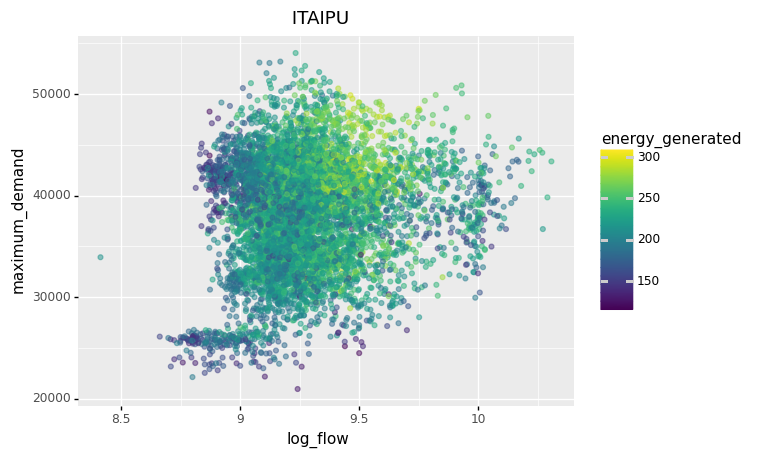

<ggplot: (142852748966)>

In [636]:
All_DF['log_flow']=np.log(All_DF.influent_flow)
dam=' ITAIPU'
DF2=All_DF[All_DF.dam_energy==dam]

ggplot(DF2,aes(y='maximum_demand',x='log_flow',color='energy_generated'))+geom_point(alpha=0.5)+ggtitle(dam)

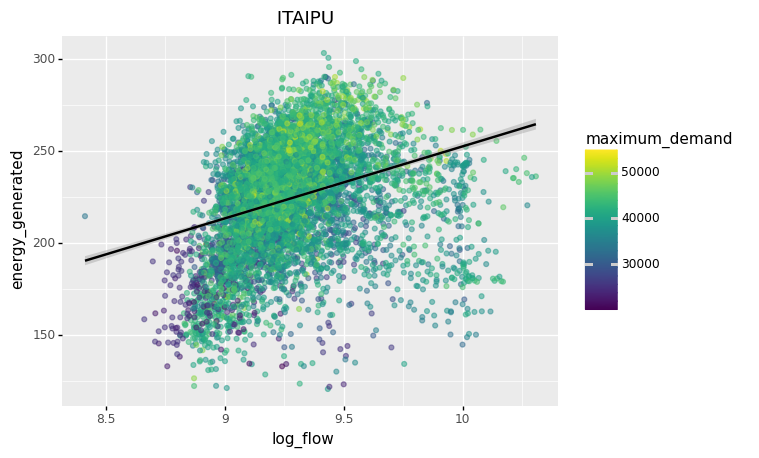

<ggplot: (142864041882)>

In [638]:
dam=' ITAIPU'
DF2=All_DF[All_DF.dam_energy==dam]

ggplot(DF2,aes(color='maximum_demand',x='log_flow',y='energy_generated'))+geom_point(alpha=0.5)+ggtitle(dam)+geom_smooth(method='lm')

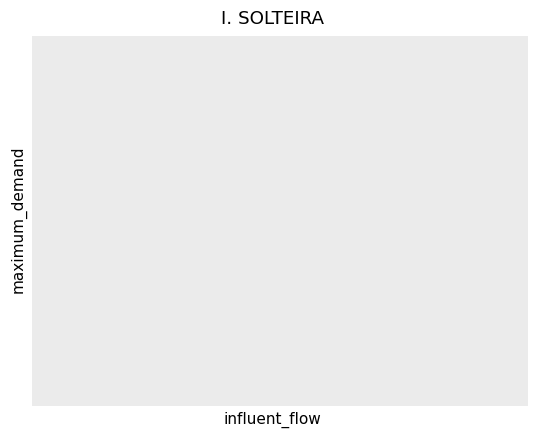

<ggplot: (142833739798)>

In [619]:
dam='I. SOLTEIRA'
DF2=All_DF[All_DF.dam_energy==dam]

ggplot(DF2,aes(y='maximum_demand',x='influent_flow',color='energy_generated'))+geom_point()+ggtitle(dam)

In [587]:
All_DF_all=All_DF.groupby(['year','month','date']).agg(maximum_demand=('maximum_demand','max'),
                                                        influent_flow=('influent_flow','sum'),
                                                        energy_generated=('energy_generated','sum')).reset_index()

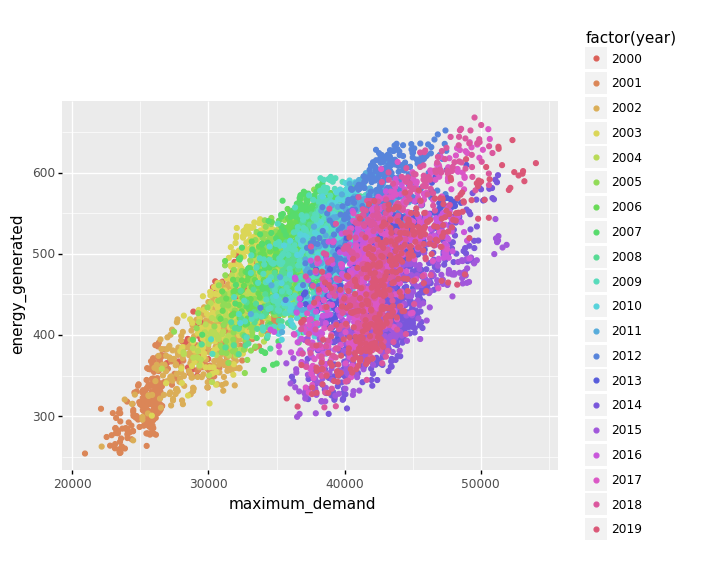

<ggplot: (142881120386)>

In [588]:
ggplot(All_DF_all,aes(x='maximum_demand',y='energy_generated',color='factor(year)'))+geom_point()

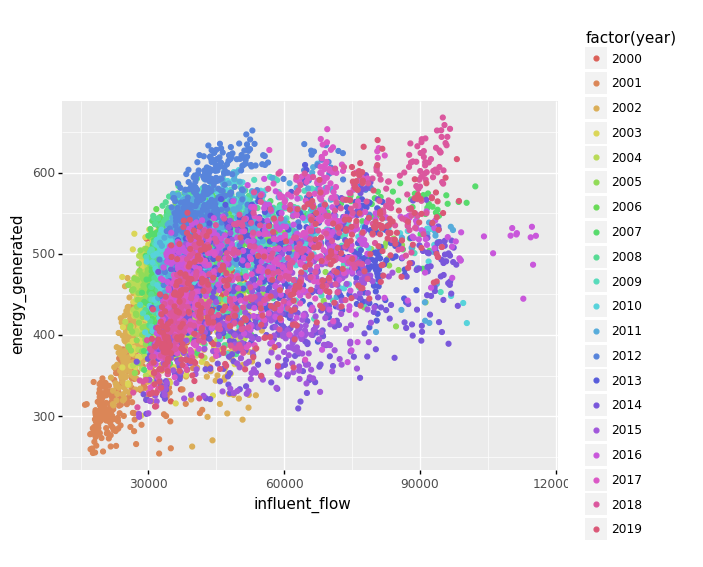

<ggplot: (142881122527)>

In [589]:
ggplot(All_DF_all,aes(x='influent_flow',y='energy_generated',color='factor(year)'))+geom_point()

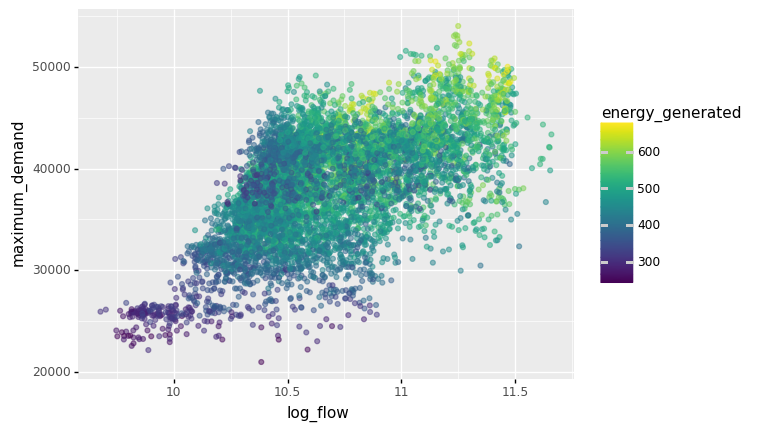

<ggplot: (142844258985)>

In [630]:
All_DF_all['log_flow']=np.log(All_DF_all.influent_flow)
ggplot(All_DF_all,aes(x='log_flow',y='maximum_demand',color='energy_generated'))+geom_point(alpha=0.5)

In [618]:
A

array(['SINOP', 'SAO MANOEL', 'SAO DOMINGOS', 'ITAPARICA',
       'FOZ DO RIO CLARO', 'COLIDER', 'BAIXO IGUACU', 'XINGO',
       'VOLTA GRANDE', 'TUCURUI', 'TRÊS MARIAS', 'TRÊS IRMÃOS', 'TOCOS',
       'TELES PIRES', 'TAQUARUÇU', 'STO ANTONIO DO JARI', 'STA.CLARA-MG',
       'SOBRAGI', 'SOBRADINHO', 'SIMPLICIO', 'SERRA DA MESA', 'SEGREDO',
       'SÃO SIMÃO', 'SAO SALVADOR', 'SAO JOSE', 'SANTONIO CM',
       'SANTO ANTONIO', 'SANTANA', 'SANTA CLARA-PR', 'SANTA BRANCA',
       'SAMUEL', 'SALTO SANTIAGO', 'SALTO PILAO', 'SALTO OSORIO',
       'SALTO GRANDE CS', 'SALTO GRANDE CM', 'SALTO CAXIAS', 'SALTO',
       'SA CARVALHO', 'S.R.VERDINHO', 'S.DO FACÃO', 'ROSANA', 'ROSAL',
       'RONDON II', 'RETIRO BAIXO', 'QUEIMADO', 'QUEBRA QUEIXO',
       'PROMISSÃO', 'PORTO PRIMAVERA', 'PORTO ESTRELA', 'PONTE NOVA',
       'PONTE DE PEDRA', 'PIRAJU', 'PIMENTAL', 'PICADA', 'PEREIRA PASSOS',
       'PEIXE ANGICAL', 'PEDRA DO CAVALO', 'PASSO SAO JOAO', 'PASSO REAL',
       'PASSO FUNDO', 'PARAIBUNA',

In [615]:
B

array([' VOLTA GRANDE (CEMIG)', ' TRÊS MARIAS', ' TRÊS IRMÃOS',
       ' SOBRAGI', ' SERRA DA MESA', ' SEN. JOSÉ ERMÍRIO DE MORAES',
       ' SÃO SIMÃO (CEMIG)', ' SANTA BRANCA', ' SALTO GRANDE (CEMIG)',
       ' RUI BARBOSA', ' ROSANA', ' PORTO COLÔMBIA', ' PEREIRA PASSOS',
       ' PCH ESCELSA', ' PCH ENERSUL', ' PCH EMAE', ' PCH CPFL',
       ' PCH CESP', ' PCH CERJ', ' PCH CEMIG', ' PCH CEMAT', ' PCH CELG',
       ' PCH CEB', ' PARAIBUNA', ' NOVA PONTE', ' NILO PECANHA',
       ' MIRANDA', ' MASCARENHAS', ' MÁRIO LOPES LEÃO', ' MARIMBONDO',
       ' MAL. MASCARENHAS DE MORAES', ' LUIZ CARLOS BARRETO DE CARVALHO',
       ' LUCAS NOGUEIRA GARCEZ', ' JAGUARI (CESP)', ' JAGUARA',
       ' ITUTINGA', ' ITUMBIARA (FURNAS)', ' ITAIPU', ' ILHA DOS POMBOS',
       ' IGARAPAVA', ' IBITINGA', ' GUILMAN - AMORIM', ' FURNAS',
       ' FUNIL (FURNAS)', ' FONTES NOVA (A+BC+SC)', ' EUCLIDES DA CUNHA',
       ' ESCOLA POLITÉCNICA', ' ESCOLA ENGENHARIA ALEXANDRE MACKENZIE',
       ' ENG. SOUZA DIAS'

In [627]:
DF_energy[DF_energy.date>='2020-01-01'].groupby('dam').agg(energy_generated=('energy_generated','mean')).sort_values('energy_generated', ascending=False).head(20)

,energy_generated
dam,
ITAIPU,164.108054
SANTO ANTÔNIO (STO. ANTONIO),48.472258
JIRAU,41.361778
COMPLEXO ILHA SOLTEIRA,36.759566
SÃO SIMÃO (CEMIG),27.877165
ENG. SERGIO MOTA (PORTO PRIMAVERA),23.680277
ENG. SOUZA DIAS,21.399408
TELES PIRES,19.278458
ITUMBIARA (FURNAS),18.354398
